In [1]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO  # Correct import for StringIO

# Connection details
account_name = "mainprojectwis"
account_key = "S4laxfCtH7dA87w7OGPHQVBfF39zGGeXGBDH65aYHGDJLXs4y+1UWHjLbmQoH38oehZ+1KukGIOy+AStlQdbKA=="
container_name = "mymaincontainer"

# Blob paths
train_blob_name = "transformed-data/hourly_weather_data.csv"  
test_blob_name = "Open-weather-API/cleaned-data/cleaned_data.csv"  # Removed extra 'mymaincontainer/'

# Connection string
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

# Connect to the Blob Service Client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Function to load data from a blob
def load_blob_to_dataframe(blob_name):
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    blob_data = blob_client.download_blob().content_as_text()
    return pd.read_csv(StringIO(blob_data))  # Use io.StringIO here

# Load training and test datasets
train = load_blob_to_dataframe(train_blob_name)
test = load_blob_to_dataframe(test_blob_name)

# Preview datasets
print("Training Data Preview:")
print(train.columns)

print("Test Data Preview:")
print(test.columns)


Training Data Preview:
Index(['temperature', 'dew_point_temperature', 'station_level_pressure',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'precipitation',
       'relative_humidity', 'visibility', 'altimeter', 'timestamp', 'hour',
       'Weather_Description', 'Sky_Cover', 'year', 'month'],
      dtype='object')
Test Data Preview:
Index(['temperature', 'dew_point_temperature', 'station_level_pressure',
       'wind_direction', 'wind_speed', 'relative_humidity', 'timestamp',
       'Weather_Description', 'Weather_Description.1', 'Sky_Cover'],
      dtype='object')


In [2]:
columns_to_keep = ['temperature', 'dew_point_temperature', 'station_level_pressure',
                   'wind_direction', 'wind_speed', 'relative_humidity', 'timestamp']

# Filter the dataset to keep only the desired columns
train = train[columns_to_keep]
test = test[columns_to_keep]

# Ensure that the data is sorted by timestamp (if not already sorted)
train = train.sort_values('timestamp')

# Impute missing values for 'station_level_pressure' using the rolling window
train['station_level_pressure'] = train['station_level_pressure'].fillna(
    train['station_level_pressure'].rolling(window=73, min_periods=1, center=True).mean()
)
# Remove rows with any NaN values
train = train.dropna()
# Check if NaN values have been filled
print("NaN values after imputation:", train.isna().sum())


NaN values after imputation: temperature               0
dew_point_temperature     0
station_level_pressure    0
wind_direction            0
wind_speed                0
relative_humidity         0
timestamp                 0
dtype: int64


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 3: Data Normalization and Reshaping

# Normalize the features (excluding 'timestamp' column)
scaler = MinMaxScaler(feature_range=(0, 1))

# Drop 'timestamp' and apply the scaler to the data
scaled_train = scaler.fit_transform(train.drop(columns=['timestamp']))
scaled_test = scaler.transform(test.drop(columns=['timestamp']))

# Create dataframes from the scaled values
scaled_train_df = pd.DataFrame(scaled_train, columns=train.columns[:-1])
scaled_test_df = pd.DataFrame(scaled_test, columns=test.columns[:-1])

# Check the first few rows of the scaled data
print("Scaled Training Data Preview:")
print(scaled_train_df.head())

print("Scaled Test Data Preview:")
print(scaled_test_df.head())

# Define a function to create time-series sequences (samples, time_steps, features)
def create_sequences(data, time_steps=60):
    X = []
    y = []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])  # Sequence of time_steps
        y.append(data[i, 0])  # Target variable (temperature)
    return np.array(X), np.array(y)

# Create sequences for the training and test data
X_train, y_train = create_sequences(scaled_train_df.values)
X_test, y_test = create_sequences(scaled_test_df.values)

# Check the new shape of the data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Scaled Training Data Preview:
   temperature  dew_point_temperature  station_level_pressure  wind_direction  \
0     0.403877               0.623090                0.485646         0.20020   
1     0.395800               0.623090                0.490431         0.20020   
2     0.386107               0.612903                0.482057         0.20020   
3     0.403877               0.631579                0.473684         0.23023   
4     0.386107               0.612903                0.453349         0.19019   

   wind_speed  relative_humidity  
0    0.413502           0.782609  
1    0.240506           0.808696  
2    0.172996           0.808696  
3    0.151899           0.808696  
4    0.109705           0.808696  
Scaled Test Data Preview:
   temperature  dew_point_temperature  station_level_pressure  wind_direction  \
0     0.546688               0.764177                0.647129         0.36036   
1     0.530695               0.746859                0.659091         0.34034   
2   

2024-12-05 23:34:18.026562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 23:34:18.838754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 23:34:19.073284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 23:34:20.884371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 23:34:25.342517: W tensorflow/comp

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 163s 18ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 2/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 163s 18ms/step - loss: 3.7090e-04 - val_loss: 6.5632e-04
Epoch 3/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 169s 19ms/step - loss: 3.4044e-04 - val_loss: 6.8760e-04
Epoch 4/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 171s 19ms/step - loss: 3.3326e-04 - val_loss: 4.4832e-04
Epoch 5/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 168s 19ms/step - loss: 3.2448e-04 - val_loss: 4.6280e-04
Epoch 6/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 166s 19ms/step - loss: 3.2297e-04 - val_loss: 2.4608e-04
Epoch 7/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 166s 19ms/step - loss: 3.1931e-04 - val_loss: 3.9897e-04
Epoch 8/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 166s 19ms/step - loss: 3.1511e-04 - val_loss: 3.8272e-04
Epoch 9/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 170s 19ms/step - loss: 3.1474e-04 - val_loss: 2.9352e-04
Epoch 10/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 172s 19ms/step - loss: 3.1500e-04 - val_loss: 3.3833e-04
Epoch 11/20
8877/

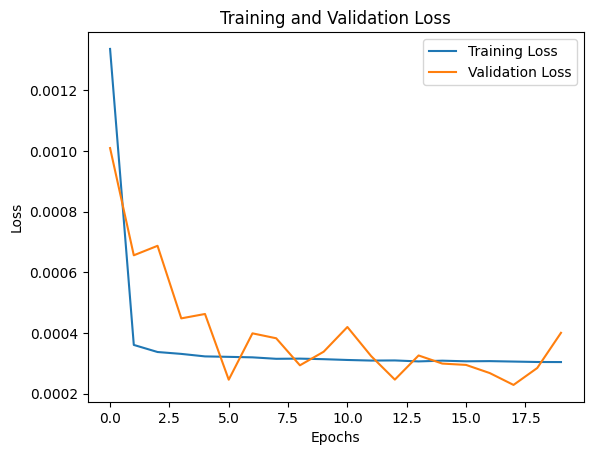

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Step 4: Build the LSTM Model

# Initialize the model
model = Sequential()

# Add LSTM layer (first LSTM layer)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add Dense layer (output layer)
model.add(Dense(units=1))  # Output temperature prediction (1 value)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to verify the architecture
model.summary()

# Step 5: Train the Model

# Train the LSTM model on the training data and validate on the test data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


2024-12-08 00:13:19.019994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 00:13:19.827338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 00:13:20.072871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 00:13:21.969107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 00:13:26.737914: W tensorflow/compiler/tf2

Epoch 1/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 217s 24ms/step - loss: 0.0026 - val_loss: 8.3503e-04
Epoch 2/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 203s 23ms/step - loss: 3.5895e-04 - val_loss: 4.1543e-04
Epoch 3/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 194s 22ms/step - loss: 3.3573e-04 - val_loss: 4.0758e-04
Epoch 4/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 192s 22ms/step - loss: 3.2354e-04 - val_loss: 4.4316e-04
Epoch 5/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 183s 21ms/step - loss: 3.2252e-04 - val_loss: 3.0674e-04
Epoch 6/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 182s 21ms/step - loss: 3.1902e-04 - val_loss: 2.7486e-04
Epoch 7/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 186s 21ms/step - loss: 3.1833e-04 - val_loss: 2.6313e-04
Epoch 8/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 184s 21ms/step - loss: 3.1424e-04 - val_loss: 4.3116e-04
Epoch 9/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 184s 21ms/step - loss: 3.1183e-04 - val_loss: 3.3224e-04
Epoch 10/20
8877/8877 ━━━━━━━━━━━━━━━━━━━━ 183s 21ms/step - loss: 3.0847e-04 - val_loss: 4.1273e-04
Epoch 11/20
8

findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: F

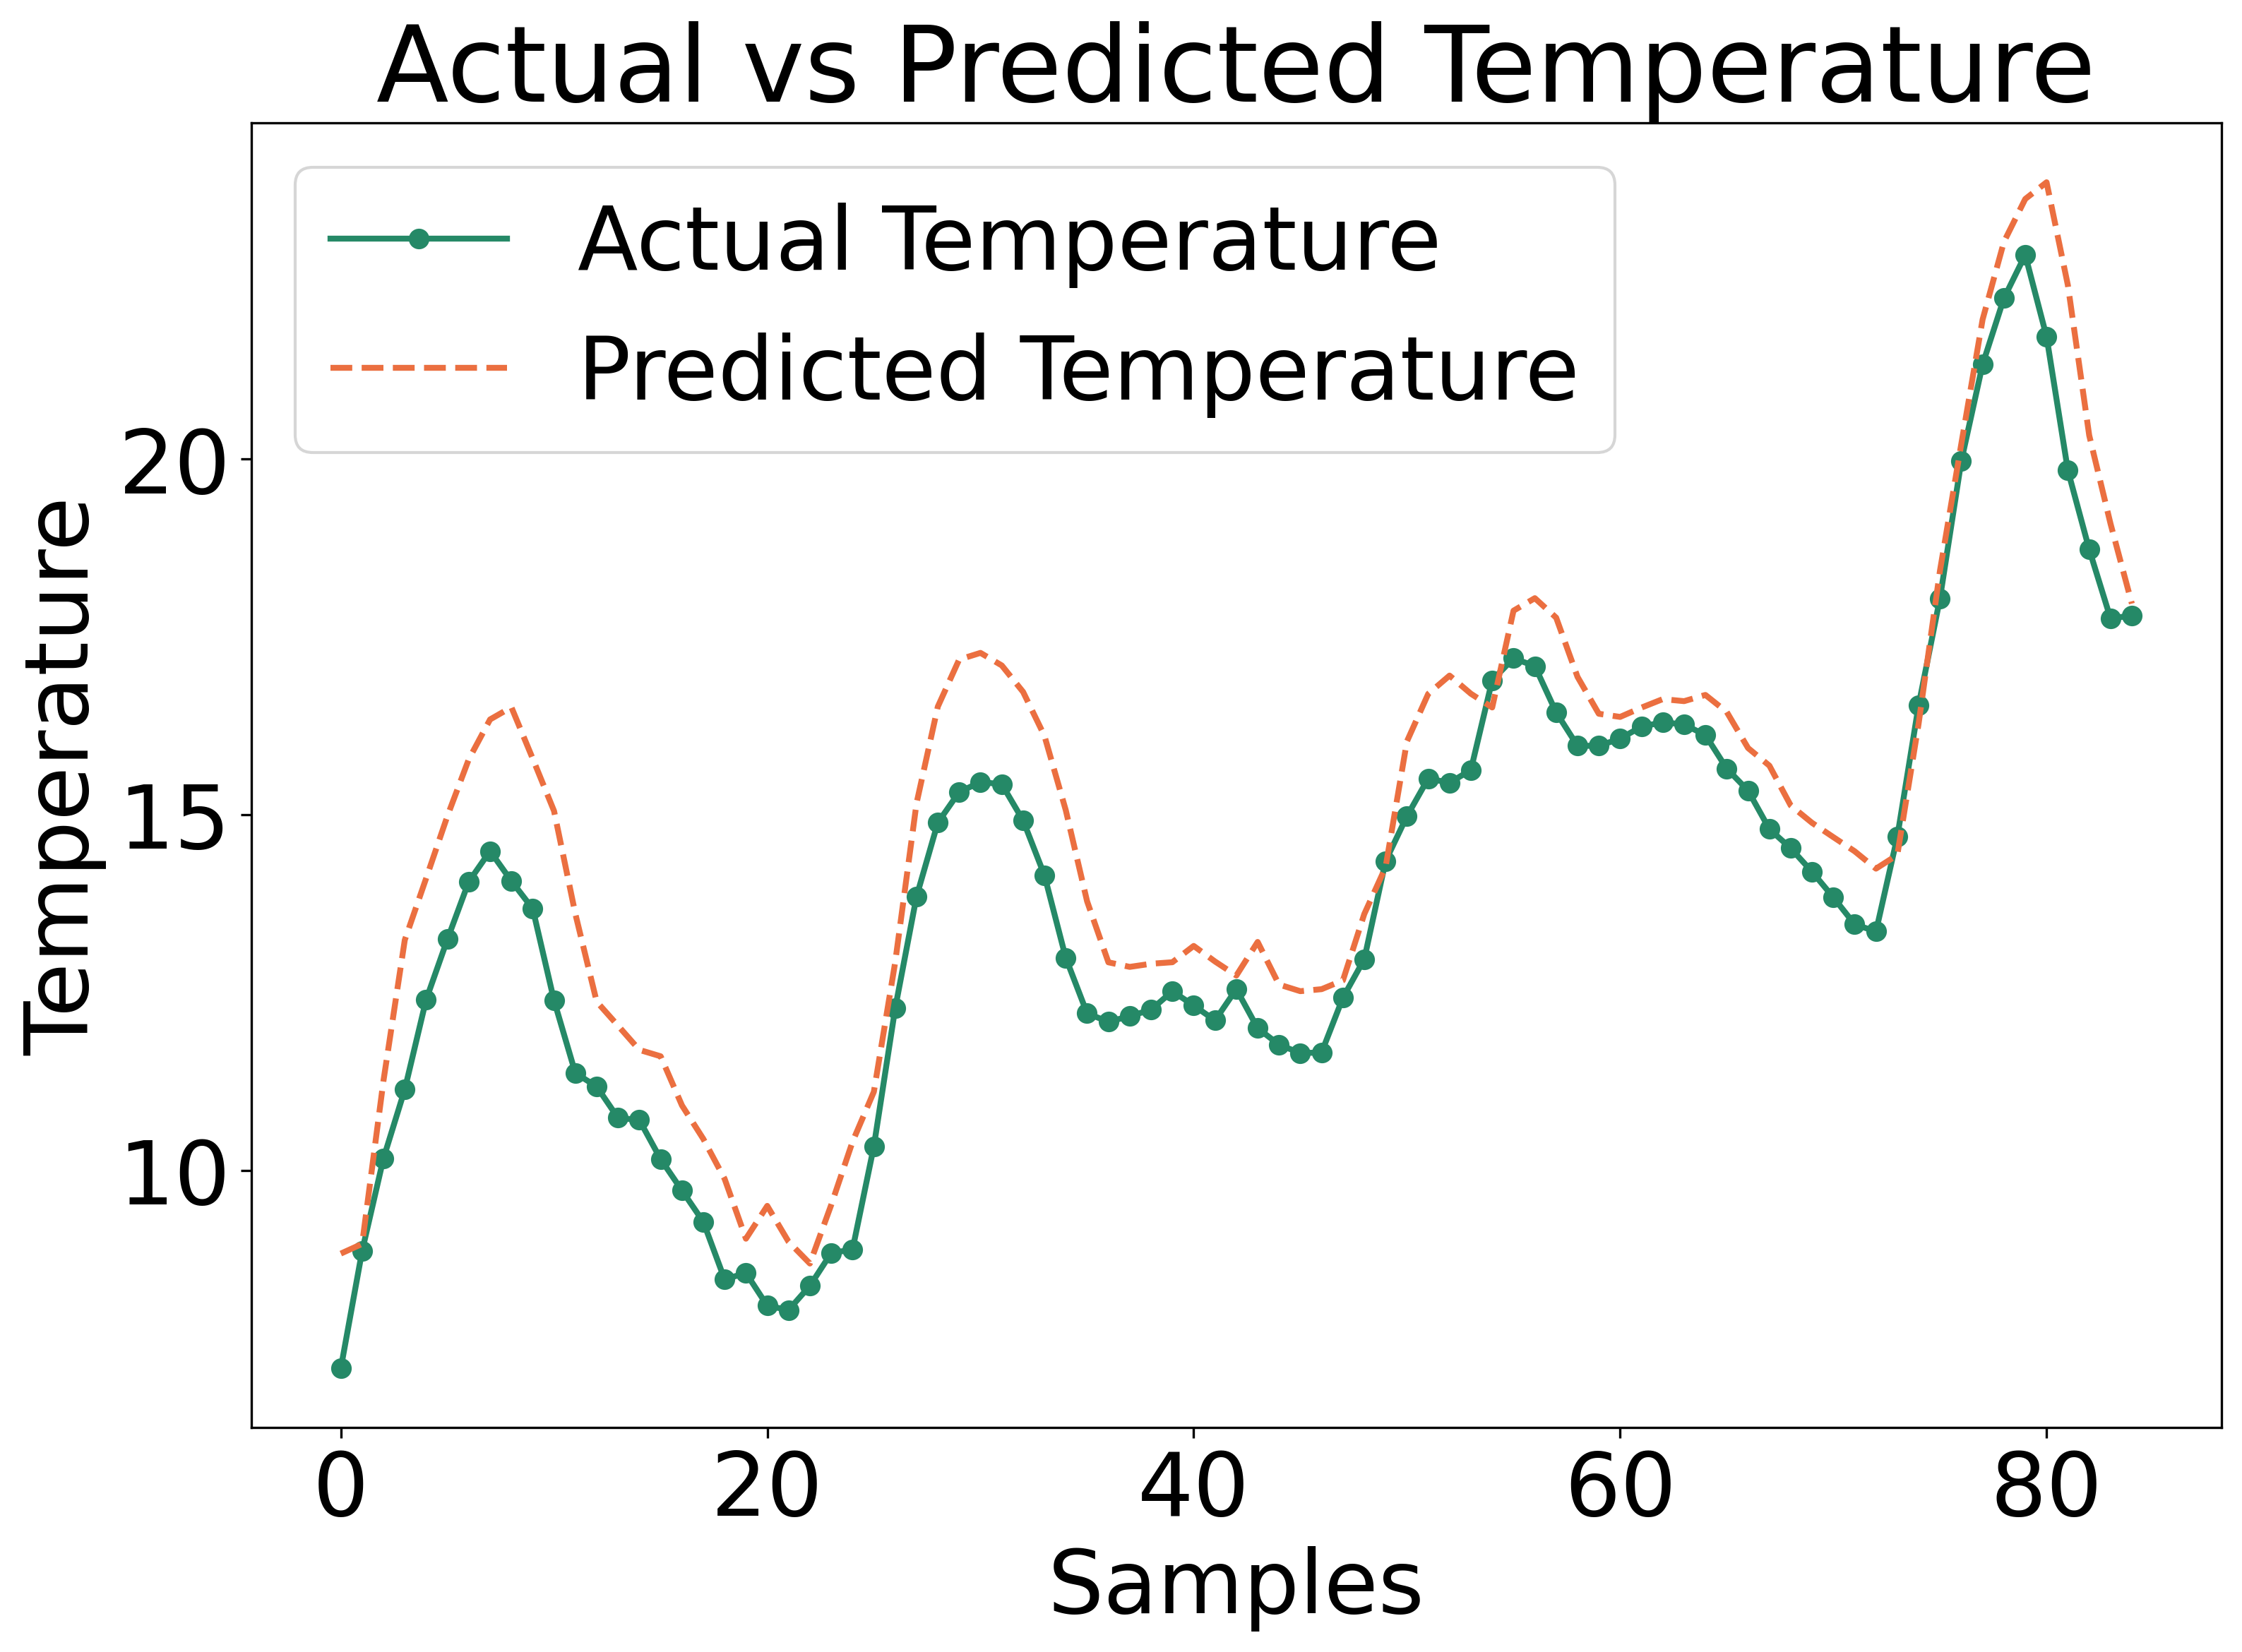

Mean Absolute Error: 1.0666897776968083
Mean Absolute Percentage Error: 8.24%


In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Step 2: Define the Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 4: Evaluate the Model
val_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Loss: {val_loss}")

# Step 5: Make Predictions
predictions = model.predict(X_test)

# Ensure y_test is a 2D array for scaling
if len(y_test.shape) == 1:
    y_test = y_test.reshape(-1, 1)


predictions_denorm = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1))], axis=1)
)[:, 0]

y_test_denorm = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], X_test.shape[2] - 1))], axis=1)
)[:, 0]

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set custom font
rcParams['font.family'] = 'Poppins'
rcParams['font.weight'] = 'medium'
rcParams['font.size'] = 30  # Global font size

# Step 7: Plot Results
plt.figure(figsize=(12, 8), dpi=300)  # Larger size and high-quality resolution

# Plot actual and predicted temperatures
plt.plot(
    y_test_denorm,
    label='Actual Temperature',
    color='#258967',  # Custom green color
    marker='o',
    linewidth=2
)
plt.plot(
    predictions_denorm,
    label='Predicted Temperature',
    color='#eb6f40',  # Custom orange color
    linestyle='--',
    linewidth=2
)

# Add legend, title, and axis labels
plt.legend()
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Samples')
plt.ylabel('Temperature')

# Save the plot as a high-resolution image
plt.savefig('actual_vs_predicted_temperature.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



# Step 8: Evaluate with Metrics
mae = mean_absolute_error(y_test_denorm, predictions_denorm)
mape = mean_absolute_percentage_error(y_test_denorm, predictions_denorm)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")



findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: F

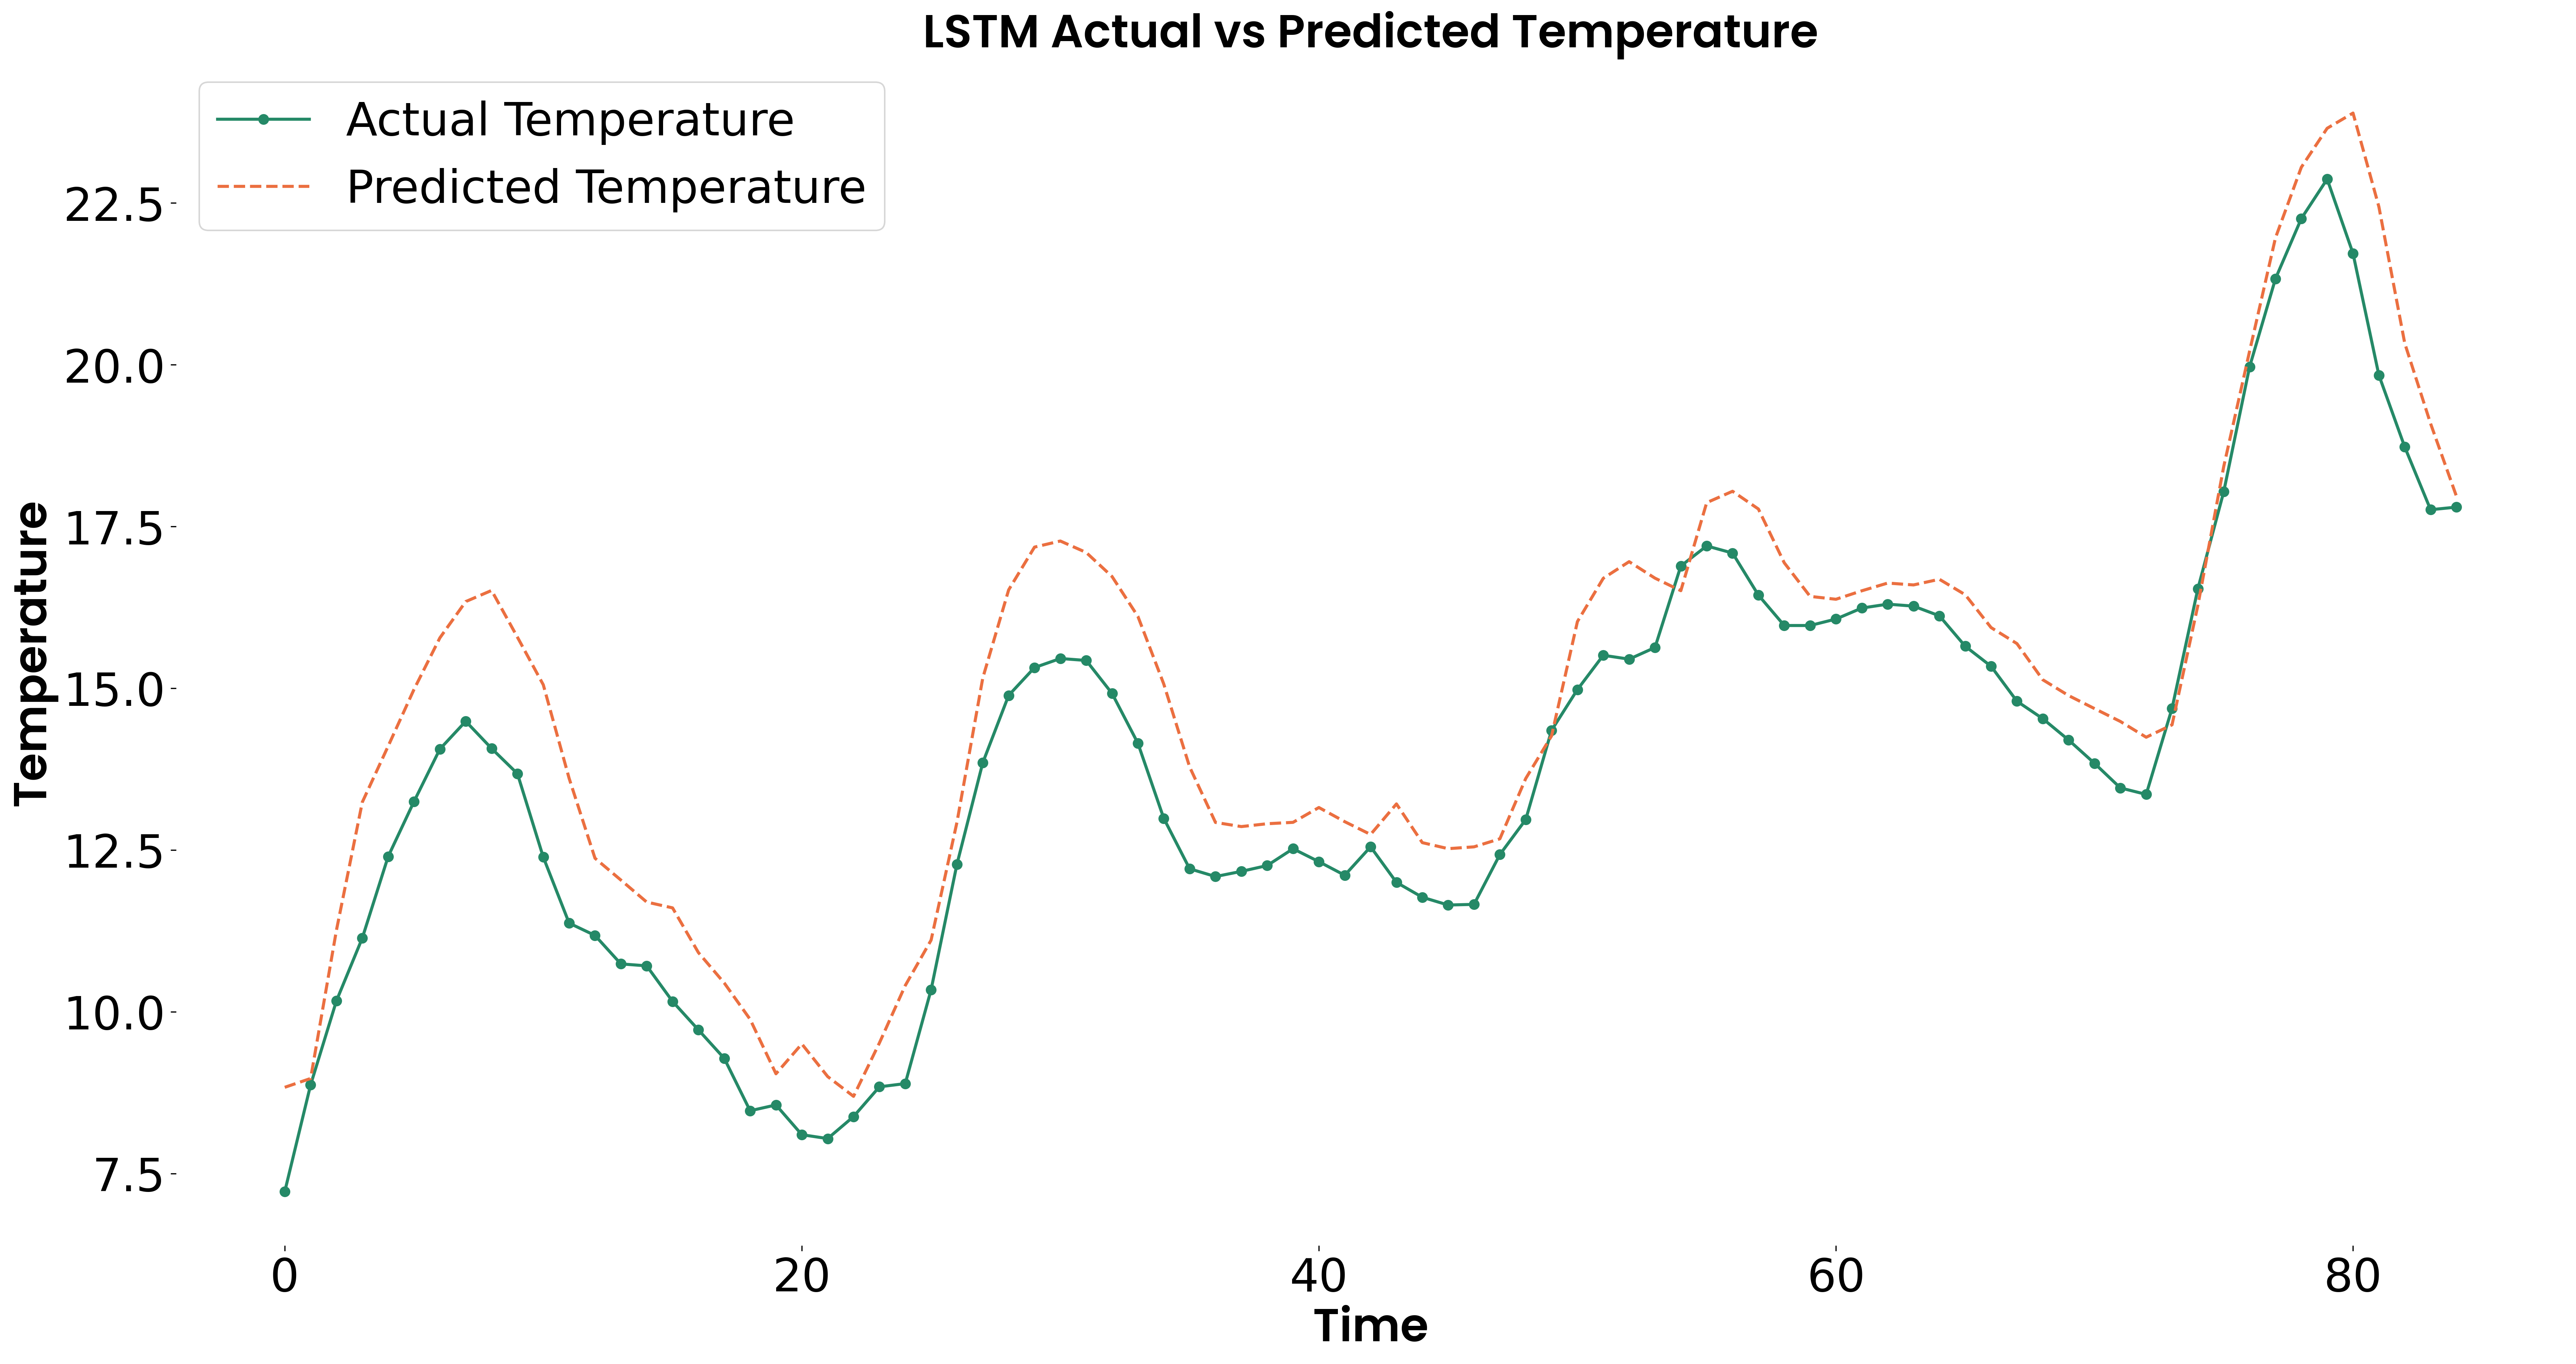

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

# Specify the path to your Poppins font file (adjust the path if needed)
poppins_path = './Poppins-SemiBold.ttf'  # Replace with your actual font file path

# Load the font
poppins_font = fm.FontProperties(fname=poppins_path)

# Update rcParams to use the custom font and set font size
rcParams['font.family'] = poppins_font.get_name()
rcParams['font.size'] = 30  # Set default text size
rcParams['font.weight'] = 'medium'

# Step 7: Plot Results
plt.figure(figsize=(28, 14), dpi=300)  # Larger size and high-quality resolution

# Plot actual and predicted temperatures
plt.plot(
    y_test_denorm,
    label='Actual Temperature',
    color='#258967',  # Custom green color
    marker='o',
    linewidth=2
)
plt.plot(
    predictions_denorm,
    label='Predicted Temperature',
    color='#eb6f40',  # Custom orange color
    linestyle='--',
    linewidth=2
)

# Remove plot borders (spines)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add legend, title, and axis labels
plt.legend()

# Add title and labels
plt.title("LSTM Actual vs Predicted Temperature", fontproperties=poppins_font)
plt.xlabel("Time", fontproperties=poppins_font)
plt.ylabel("Temperature", fontproperties=poppins_font)


# Save the plot as a high-resolution image
plt.savefig('actual_vs_predicted_temperature_no_border.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
